In [14]:
import numpy as np
import tensorflow as tf
import lightgbm as lgb

from src.loaders.data_loader import load_train_data, load_test_data
from src.loaders.data_loader import generate_test_data, load_submission_data


np.random.seed(42)

In [15]:
from src.preprocessors.add_columns import add_sin_cos_day, add_sin_cos_hour, add_ghi

def feature_engineering(df):
#     df = add_sin_cos_day(df)
#     df = add_sin_cos_hour(df)
    df = add_ghi(df)

#     df["TARGET_ROLLING_MEAN_3"] = df["TARGET"].rolling(4).mean()
#     df["TARGET_ROLLING_MEAN_5"] = df["TARGET"].rolling(6).mean()
#     df["TARGET_ROLLING_MEAN_11"] = df["TARGET"].rolling(12).mean()
#     df["TARGET_ROLLING_MEAN_23"] = df["TARGET"].rolling(24).mean()
    df["TARGET_ROLLING_MEAN_47"] = df["TARGET"].rolling(48).mean()
    
#     df["DHI_ROLLING_MEAN_3"] = df["DHI"].rolling(4).mean()
#     df["DHI_ROLLING_MEAN_5"] = df["DHI"].rolling(6).mean()
#     df["DHI_ROLLING_MEAN_11"] = df["DHI"].rolling(12).mean()
#     df["DHI_ROLLING_MEAN_23"] = df["DHI"].rolling(24).mean()
    df["DHI_ROLLING_MEAN_47"] = df["DHI"].rolling(48).mean()
    
#     df["DNI_ROLLING_MEAN_3"] = df["DNI"].rolling(4).mean()
#     df["DNI_ROLLING_MEAN_5"] = df["DNI"].rolling(6).mean()
#     df["DNI_ROLLING_MEAN_11"] = df["DNI"].rolling(12).mean()
#     df["DNI_ROLLING_MEAN_23"] = df["DNI"].rolling(24).mean()
    df["DNI_ROLLING_MEAN_47"] = df["DNI"].rolling(48).mean()
    
#     df["GHI_ROLLING_MEAN_3"] = df["GHI"].rolling(4).mean()
#     df["GHI_ROLLING_MEAN_5"] = df["GHI"].rolling(6).mean()
#     df["GHI_ROLLING_MEAN_11"] = df["GHI"].rolling(12).mean()
#     df["GHI_ROLLING_MEAN_23"] = df["GHI"].rolling(24).mean()
    df["GHI_ROLLING_MEAN_47"] = df["GHI"].rolling(48).mean()
    
    scaled_rh = (df["RH"]) / 100
    _mean = df["T"].rolling(96).mean()
    _std = df["T"].rolling(96).std()
    df["SCALED_RH"] = scaled_rh * (df["T"] - _mean) / _std
    df["RH_CROSS_T"] = df["RH"] * df["T"]
    
    df.drop(["Day", "Hour", "Minute", "WS", "RH", "T", ], axis=1, inplace=True)
    
    return df

In [16]:
def learn(x_day, train, valid, test, columns):
    x_shape = x_day * train.shape[2]

    train_x, train_y_1, train_y_2 = train[:, :x_day, :].reshape(-1, x_shape), train[:, x_day:x_day + 1, target_index].reshape(-1), train[:, x_day + 1:, target_index].reshape(-1)
    valid_x, valid_y_1, valid_y_2 = valid[:, :x_day, :].reshape(-1, x_shape), valid[:, x_day:x_day + 1, target_index].reshape(-1), valid[:, x_day + 1:, target_index].reshape(-1)
    test_x, test_y_1, test_y_2 = test[:, :x_day, :].reshape(-1, x_shape), test[:, x_day:x_day + 1, target_index].reshape(-1), test[:, x_day + 1:, target_index].reshape(-1)
    
    
    train_1_dataset = lgb.Dataset(train_x, label=train_y_1, feature_name=columns)
    train_2_dataset = lgb.Dataset(train_x, label=train_y_2, feature_name=columns)
    valid_1_dataset = lgb.Dataset(valid_x, label=valid_y_1, feature_name=columns)
    valid_2_dataset = lgb.Dataset(valid_x, label=valid_y_2, feature_name=columns)
    test_1_dataset = lgb.Dataset(test_x, label=test_y_1, feature_name=columns)
    test_2_dataset = lgb.Dataset(test_x, label=test_y_2, feature_name=columns)
    
    submission_df = load_submission_data()

    r = 0
    bst_1_list = []
    bst_2_list = []
    for i in range(1, 10):
        q = i/10
        result = []
        param = {
        'application': 'quantile',
        'learning_rate': 0.05,
        'max_depth': 3,
        'num_leaves': 8,
        'n_jobs': 17,
        'seed': 42,
        'bagging_freq': 100,
        'feature_fraction': 0.8,
        'bagging_fraction': 0.8,
        'drop_rate': 0.2,
        'early_stopping_round': 10,
        'alpha': q,
        'boosting': 'gbdt',
        }
        
        num_round = 5000
        bst_1 = lgb.train(param, train_1_dataset, num_round, valid_sets=[valid_1_dataset])
        bst_2 = lgb.train(param, train_2_dataset, num_round, valid_sets=[valid_2_dataset])
        
        bst_1_list.append(bst_1)
        bst_2_list.append(bst_2)
        
        y_pred_1 = bst_1.predict(test_x)
        y_pred_2 = bst_2.predict(test_x)
        r += np.mean(np.maximum(q * (test_y_1 - y_pred_1), (q - 1) * (test_y_1 - y_pred_1)))
        r += np.mean(np.maximum(q * (test_y_2 - y_pred_2), (q - 1) * (test_y_2 - y_pred_2)))
        
        for td in generate_test_data():
            td = feature_engineering(td)
            td = td.values.reshape(7, 48, -1)[(7 - x_day):, :, ].transpose(1, 0, 2).reshape(48, -1)
            result.append(bst_1.predict(td))
            result.append(bst_2.predict(td))
        
        submission_df[f"q_{q}"] = np.array(result).reshape(-1)
    
    return r/18, submission_df, bst_1_list, bst_2_list

In [17]:
raw_df = load_train_data()

preprocessed_df = feature_engineering(raw_df)
preprocessed_df.dropna(inplace=True)
preprocessed_df.head(10)

target_index = [i for i, s in enumerate(preprocessed_df.columns) if s == "TARGET"][0]

one_day = 48
x_day = 5
one_set = one_day * (x_day + 2)


set_df = []
target_df = []
target_df = []
for i in range(0, len(preprocessed_df) - one_set + 1, 48):
    tmp = preprocessed_df[i:i + one_set].values
    
    tmp = tmp.reshape((x_day + 2), 48, -1)
    tmp = tmp.transpose(1, 0, 2)
    x = tmp[:, :x_day, ]
    y = tmp[:, x_day:, ]
    
    for j in range(48):
        set_df.append(x[j, :, :])
        target_df.append(y[j, :, :])
           
set_df = np.array(set_df)
target_df = np.array(target_df)
set_df.shape, target_df.shape

all_df = np.concatenate((set_df, target_df), axis=1)

train = []
valid = []
test = []

length = all_df.shape[0]
boundary = [
    (slice(0, int(length * 0.6)),slice(int(length * 0.6), int(length * 0.9)), slice(int(length * 0.9), int(length * 1.0))),
    (slice(int(length * 0.1), int(length * 0.7)),slice(int(length * 0.7), int(length * 1)), slice(int(length * 0), int(length * 0.1))),    
    (slice(int(length * 0.3), int(length * 0.9)),slice(int(length * 0.9), int(length * 1)), slice(int(length * 0), int(length * 0.3))),
    (slice(int(length * 0.4), int(length * 1)),slice(int(length * 0), int(length * 0.3)), slice(int(length * 0.3), int(length * 0.4))),
]

total_error = 0
result_list = []

for train_slice, valid_slice, test_slice in boundary:
    train, valid, test = all_df[train_slice], all_df[valid_slice], all_df[test_slice]
    
    columns = [f"{day}_{column}" for day in range(x_day) for column in preprocessed_df.columns]
    
    error, result_df, result_bst_1, result_bst_2 = learn(x_day, train, valid, test, columns)
    total_error += error
    result_list.append(result_df)
    
    
    

C:\Users\bees1\anaconda3\envs\dacon\lib\site-packages\lightgbm\engine.py:156: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.79224
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.77645
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.75886
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.73785
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.72233
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.70795
[Lig

[155]	valid_0's quantile: 1.45519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 1.45517
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 1.45502
[158]	valid_0's quantile: 1.45487
[159]	valid_0's quantile: 1.45476
[160]	valid_0's quantile: 1.45459
[161]	valid_0's quantile: 1.45452
[162]	valid_0's quantile: 1.45449
[163]	valid_0's quantile: 1.45428
[164]	valid_0's quantile: 1.45424
[165]	valid_0's quantile: 1.45402
[166]	valid_0's quantile: 1.45409
[167]	valid_0's quantile: 1.45399
[168]	valid_0's quantile: 1.45391
[169]	valid_0's quantile: 1.45381
[170]	valid_0's quantile: 1.45374
[171]	valid_0's quantile: 1.4538
[172]	valid_0's quantile: 1.45372
[173]	valid_0's quantile: 1.4538
[174]	valid_0's quantile: 1.45384
[175]	valid_0's quantile: 1.45385
[176]	valid_0's quantile: 1.45377
[177]	valid_0's quantile: 1.45365
[178]	valid_0's quantile: 1.45374
[179]	valid_0's quantile: 1.45402
[1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002875 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.55636
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.4861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.41135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.34598
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.29262
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.23107
[Ligh

[15]	valid_0's quantile: 2.85034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's quantile: 2.82526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's quantile: 2.79999
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's quantile: 2.77591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's quantile: 2.74901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's quantile: 2.72521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's quantile: 2.70779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's quantile: 2.68998
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's quantile: 2.67051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's quantile: 2.6

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.28549
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.15181
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.00309
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.88006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.74111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.61046
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's quantile: 3.7636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's quantile: 3.70861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's quantile: 3.65575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's quantile: 3.61414
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's quantile: 3.56721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's quantile: 3.53125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's quantile: 3.49094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's quantile: 3.453
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's quantile: 3.4229
[LightGBM] [Warning] No further 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 6.97342
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.72132
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.47344
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.2499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.02933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 5.82616
[Ligh

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[153]	valid_0's quantile: 2.85077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 2.85081
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's quantile: 2.85086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 2.85083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 2.85069
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 2.85069
Early stopping, best iteration is:
[148]	valid_0's quantile: 2.85042
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of us

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 3.01005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 3.0097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 3.0098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 3.00849
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 3.00816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 3.00817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 3.00722
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 3.00721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 3.007
[LightGBM] [Warning] No

[159]	valid_0's quantile: 2.74347
[160]	valid_0's quantile: 2.74347
[161]	valid_0's quantile: 2.743
[162]	valid_0's quantile: 2.74331
[163]	valid_0's quantile: 2.74259
[164]	valid_0's quantile: 2.74236
[165]	valid_0's quantile: 2.7422
[166]	valid_0's quantile: 2.74153
[167]	valid_0's quantile: 2.74163
[168]	valid_0's quantile: 2.74142
[169]	valid_0's quantile: 2.74133
[170]	valid_0's quantile: 2.74118
[171]	valid_0's quantile: 2.74118
[172]	valid_0's quantile: 2.74087
[173]	valid_0's quantile: 2.74035
[174]	valid_0's quantile: 2.73984
[175]	valid_0's quantile: 2.74048
[176]	valid_0's quantile: 2.74055
[177]	valid_0's quantile: 2.74012
[178]	valid_0's quantile: 2.7404
[179]	valid_0's quantile: 2.74018
[180]	valid_0's quantile: 2.73982
[181]	valid_0's quantile: 2.73941
[182]	valid_0's quantile: 2.73923
[183]	valid_0's quantile: 2.73874
[184]	valid_0's quantile: 2.73901
[185]	valid_0's quantile: 2.73904
[186]	valid_0's quantile: 2.7389
[187]	valid_0's quantile: 2.73891
[188]	valid_0's qua

[86]	valid_0's quantile: 2.95726
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's quantile: 2.95506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's quantile: 2.95218
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's quantile: 2.9489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's quantile: 2.94893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's quantile: 2.94626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's quantile: 2.94518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's quantile: 2.94477
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's quantile: 2.94222
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[95]	valid_0's quantile: 2.94

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Info] Start training from score 10.134234
[1]	valid_0's quantile: 9.93904
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.46332
[3]	valid_0's quantile: 9.01765
[4]	valid_0's quantile: 8.60289
[5]	valid_0's quantile: 8.22054
[6]	valid_0's quantile: 7.86088
[7]	valid_0's quantile: 7.52562
[8]	valid_0's quantile: 7.20958
[9]	valid_0's quantile: 6.91709
[10]	valid_0's quantile: 6.64363
[11]	valid_0's quantile: 6.39394
[12]	valid_0's quantile: 6.159
[13]	valid_0's quantile: 5.93818
[14]	valid_0's quantile: 5.72879
[15]	valid_0's quantile: 5.53049
[16]	valid_0's quantile: 5.34855
[17]	valid_0's quantile: 5.17698
[18]	valid_0's quantile: 5.01641
[19]	vali

[127]	valid_0's quantile: 2.47904
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 2.47843
[129]	valid_0's quantile: 2.47752
[130]	valid_0's quantile: 2.47694
[131]	valid_0's quantile: 2.47635
[132]	valid_0's quantile: 2.47617
[133]	valid_0's quantile: 2.47558
[134]	valid_0's quantile: 2.47536
[135]	valid_0's quantile: 2.47439
[136]	valid_0's quantile: 2.47356
[137]	valid_0's quantile: 2.47302
[138]	valid_0's quantile: 2.47227
[139]	valid_0's quantile: 2.47186
[140]	valid_0's quantile: 2.47131
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 2.47039
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 2.4704
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 2.46974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 2.46926
[LightGBM] [Wa

[102]	valid_0's quantile: 2.64051
[103]	valid_0's quantile: 2.639
[104]	valid_0's quantile: 2.63921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[105]	valid_0's quantile: 2.63797
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.63626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[107]	valid_0's quantile: 2.63522
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[108]	valid_0's quantile: 2.63205
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 2.63017
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 2.62754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's quantile: 2.62564
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 2.6244
[LightGBM] [Warning] No furth

[241]	valid_0's quantile: 2.56231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's quantile: 2.56275
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[243]	valid_0's quantile: 2.56246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's quantile: 2.56129
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's quantile: 2.56108
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's quantile: 2.56107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's quantile: 2.56098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's quantile: 2.56034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[249]	valid_0's quantile: 2.56005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's qua

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 2.01882
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 2.0186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 2.0179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 2.01754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's quantile: 2.01693
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's quantile: 2.01676
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's quantile: 2.01705
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 2.01682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's quantile: 2.01668
[LightGBM] [Warning] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[283]	valid_0's quantile: 1.9912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[284]	valid_0's quantile: 1.99121
Early stopping, best iteration is:
[274]	valid_0's quantile: 1.99115
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Info] Start training from score 25.148743
[1]	valid_0's quantile: 10.0871
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.59329
[3]	valid_0's quantile: 9.13092
[4]	valid_0's quantile: 8.70657
[5]	valid_0's quantile: 8.31013
[6]	valid_0's quantile: 7.93991
[7]	valid_0's quantile: 7.59092
[8]	valid_0's quantile: 7.2664
[9]	valid_0's quantile: 6.96185
[10]	valid_0's quan

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 2.14582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 2.1457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 2.1451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 2.14535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 2.14489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 2.1443
[139]	valid_0's quantile: 2.14423
[140]	valid_0's quantile: 2.14332
[141]	valid_0's quantile: 2.14312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 2.14274
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 2.14098
[144]	valid_0's quantile: 2.1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Info] Start training from score 43.160534
[1]	valid_0's quantile: 8.75439
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.35934
[3]	valid_0's quantile: 7.96878
[4]	valid_0's quantile: 7.60895
[5]	valid_0's quantile: 7.26302
[6]	valid_0's quantile: 6.93691
[7]	valid_0's quantile: 6.62228
[8]	valid_0's quantile: 6.33094
[9]	valid_0's quantile: 6.05137
[10]	valid_0's quantile: 5.78909
[11]	valid_0's quantile: 5.54011
[12]	valid_0's quantile: 5.30352
[13]	valid_0's quantile: 5.08594
[14]	valid_0's quantile: 4.87578
[15]	valid_0's quantile: 4.68376
[16]	valid_0's quantile: 4.5008
[17]	valid_0's quantile: 4.32514
[18]	valid_0's quantile: 4.16033
[19]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[154]	valid_0's quantile: 1.45721
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[155]	valid_0's quantile: 1.45672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 1.4566
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 1.45646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[158]	valid_0's quantile: 1.45633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 1.45609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 1.45596
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's quantile: 1.45569
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's quantile: 1.45554
[LightGBM] [Warning]

[305]	valid_0's quantile: 1.43151
[306]	valid_0's quantile: 1.4312
[307]	valid_0's quantile: 1.43109
[308]	valid_0's quantile: 1.43045
[309]	valid_0's quantile: 1.43044
[310]	valid_0's quantile: 1.43012
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's quantile: 1.43009
[312]	valid_0's quantile: 1.42969
[313]	valid_0's quantile: 1.4296
[314]	valid_0's quantile: 1.4296
[315]	valid_0's quantile: 1.42949
[316]	valid_0's quantile: 1.42947
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[317]	valid_0's quantile: 1.42936
[318]	valid_0's quantile: 1.42948
[319]	valid_0's quantile: 1.42946
[320]	valid_0's quantile: 1.42941
[321]	valid_0's quantile: 1.42952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[322]	valid_0's quantile: 1.42891
[323]	valid_0's quantile: 1.4289
[324]	valid_0's quantile: 1.42885
[325]	valid_0's quantile: 1.42885
[326]	valid_0's quantile: 1.42885
[327]	valid_0's quantile: 1.428

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002427 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Info] Start training from score 43.166229
[1]	valid_0's quantile: 8.75629
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.34009
[3]	valid_0's quantile: 7.95228
[4]	valid_0's quantile: 7.60244
[5]	valid_0's quantile: 7.26455
[6]	valid_0's quantile: 6.93782
[7]	valid_0's quantile: 6.62827
[8]	valid_0's quantile: 6.33629
[9]	valid_0's quantile: 6.059
[10]	valid_0's quantile: 5.79594
[11]	valid_0's quantile: 5.55079
[12]	valid_0's quantile: 5.32185
[13]	valid_0's quantile: 5.10492
[14]	valid_0's quantile: 4.90321
[15]	valid_0's quantile: 4.71503
[16]	valid_0's quantile: 4.53577
[17]	valid_0's quantile: 4.36502
[18]	valid_0's quantile: 4.20542
[19]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's quantile: 1.54791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's quantile: 1.54749
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's quantile: 1.54685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's quantile: 1.54582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's quantile: 1.54558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's quantile: 1.54543
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's quantile: 1.54534
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's quantile: 1.54493
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's quantile: 1.54481
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's quantile: 1.51743
[337]	valid_0's quantile: 1.51745
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's quantile: 1.51735
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's quantile: 1.51701
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's quantile: 1.51696
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's quantile: 1.51672
[342]	valid_0's quantile: 1.51668
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's quantile: 1.51679
[344]	valid_0's quantile: 1.51681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's quantile: 1.5168
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's quantile: 1.51682
[LightGBM] [Warning] No fur

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31305, number of used features: 50
[LightGBM] [Info] Start training from score 63.988426
[1]	valid_0's quantile: 5.75166
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.59041
[3]	valid_0's quantile: 5.45047
[4]	valid_0's quantile: 5.29658
[5]	valid_0's quantile: 5.15474
[6]	valid_0's quantile: 5.01875
[7]	valid_0's quantile: 4.89084
[8]	valid_0's quantile: 4.76165
[9]	valid_0's quantile: 4.64529
[10]	valid_0's quantile: 4.54104
[11]	valid_0's quantile: 4.42377
[12]	valid_0's quantile: 4.27484
[13]	valid_0's quantile: 4.16879
[14]	valid_0's quantile: 4.06106
[15]	valid_0's quantile: 3.95909
[16]	valid_0's quantile: 3.8599
[17]	valid_0's quantile: 3.76104
[18]	valid_0's quantile: 3.63915
[19]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's quantile: 0.851472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 0.851412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 0.851406
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's quantile: 0.851245
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 0.851068
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 0.850995
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 0.850917
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 0.850898
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 0.850809
[LightGBM]

[376]	valid_0's quantile: 0.837117
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's quantile: 0.837091
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's quantile: 0.83703
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's quantile: 0.836939
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's quantile: 0.836768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[381]	valid_0's quantile: 0.836443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[382]	valid_0's quantile: 0.836318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[383]	valid_0's quantile: 0.83623
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[384]	valid_0's quantile: 0.835977
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[385]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[528]	valid_0's quantile: 0.82744
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[529]	valid_0's quantile: 0.827384
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[530]	valid_0's quantile: 0.827236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[531]	valid_0's quantile: 0.826957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[532]	valid_0's quantile: 0.826926
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[533]	valid_0's quantile: 0.826791
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[534]	valid_0's quantile: 0.826626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[535]	valid_0's quantile: 0.826632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[536]	valid_0's quantile: 0.826485
[LightGBM] 

[6]	valid_0's quantile: 5.04507
[7]	valid_0's quantile: 4.92211
[8]	valid_0's quantile: 4.80456
[9]	valid_0's quantile: 4.68159
[10]	valid_0's quantile: 4.57353
[11]	valid_0's quantile: 4.46421
[12]	valid_0's quantile: 4.3584
[13]	valid_0's quantile: 4.25236
[14]	valid_0's quantile: 4.15454
[15]	valid_0's quantile: 4.05808
[16]	valid_0's quantile: 3.93636
[17]	valid_0's quantile: 3.81097
[18]	valid_0's quantile: 3.68742
[19]	valid_0's quantile: 3.57378
[20]	valid_0's quantile: 3.46317
[21]	valid_0's quantile: 3.35704
[22]	valid_0's quantile: 3.25641
[23]	valid_0's quantile: 3.15908
[24]	valid_0's quantile: 3.06855
[25]	valid_0's quantile: 2.98563
[26]	valid_0's quantile: 2.90071
[27]	valid_0's quantile: 2.82039
[28]	valid_0's quantile: 2.73964
[29]	valid_0's quantile: 2.6603
[30]	valid_0's quantile: 2.58602
[31]	valid_0's quantile: 2.5145
[32]	valid_0's quantile: 2.44456
[33]	valid_0's quantile: 2.37577
[34]	valid_0's quantile: 2.30923
[35]	valid_0's quantile: 2.24434
[36]	valid_0's qu

[203]	valid_0's quantile: 0.909468
[204]	valid_0's quantile: 0.909423
[205]	valid_0's quantile: 0.909067
[206]	valid_0's quantile: 0.909027
[207]	valid_0's quantile: 0.908691
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 0.908535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 0.908496
[210]	valid_0's quantile: 0.908448
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[211]	valid_0's quantile: 0.908312
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[212]	valid_0's quantile: 0.907809
[213]	valid_0's quantile: 0.907774
[214]	valid_0's quantile: 0.907692
[215]	valid_0's quantile: 0.907612
[216]	valid_0's quantile: 0.907539
[217]	valid_0's quantile: 0.907448
[218]	valid_0's quantile: 0.907077
[219]	valid_0's quantile: 0.906858
[220]	valid_0's quantile: 0.906798
[221]	valid_0's quantile: 0.906776
[222]	valid_0's quantile: 0.906763


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.85339
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.83578
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.81498
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.79641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.77587
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.75783
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's quantile: 1.6948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	valid_0's quantile: 1.68375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's quantile: 1.67841
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's quantile: 1.67155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	valid_0's quantile: 1.66452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's quantile: 1.65505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's quantile: 1.64652
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's quantile: 1.63953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's quantile: 1.63543
[LightGBM] [Warning] No furth

[35]	valid_0's quantile: 2.67866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's quantile: 2.67141
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's quantile: 2.66567
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	valid_0's quantile: 2.65814
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[39]	valid_0's quantile: 2.65258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's quantile: 2.64671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[41]	valid_0's quantile: 2.6425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[42]	valid_0's quantile: 2.6355
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[43]	valid_0's quantile: 2.63144
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[44]	valid_0's quantile: 2.625

[31]	valid_0's quantile: 3.40968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's quantile: 3.387
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's quantile: 3.36362
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's quantile: 3.34413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[35]	valid_0's quantile: 3.33043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[36]	valid_0's quantile: 3.3121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[37]	valid_0's quantile: 3.29405
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[38]	valid_0's quantile: 3.2768
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[39]	valid_0's quantile: 3.26106
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's quantile: 3.24661

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 3.02848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's quantile: 3.02825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's quantile: 3.02866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's quantile: 3.02792
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[198]	valid_0's quantile: 3.02816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[199]	valid_0's quantile: 3.028
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[200]	valid_0's quantile: 3.02826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 3.02794
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 3.02789
[LightGBM] [Warning] 

[165]	valid_0's quantile: 3.03217
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's quantile: 3.0322
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's quantile: 3.03235
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's quantile: 3.03216
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's quantile: 3.03203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's quantile: 3.03204
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's quantile: 3.03149
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's quantile: 3.03145
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's quantile: 3.03172
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's quan

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[121]	valid_0's quantile: 3.17929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[122]	valid_0's quantile: 3.17967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[123]	valid_0's quantile: 3.1796
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[124]	valid_0's quantile: 3.17957
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's quantile: 3.17946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 3.17949
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 3.17964
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 3.17956
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 3.17881
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 2.88928
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 2.88889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 2.88881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 2.88866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 2.88723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 2.88728
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's quantile: 2.88732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[196]	valid_0's quantile: 2.88723
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[197]	valid_0's quantile: 2.88729
[LightGBM] [Warning

[68]	valid_0's quantile: 3.1793
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's quantile: 3.17391
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's quantile: 3.16811
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's quantile: 3.16307
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's quantile: 3.15685
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's quantile: 3.15114
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's quantile: 3.14643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's quantile: 3.14215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's quantile: 3.13758
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[77]	valid_0's quantile: 3.13

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002798 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 9.289123
[1]	valid_0's quantile: 10.2519
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.78498
[3]	valid_0's quantile: 9.34581
[4]	valid_0's quantile: 8.93534
[5]	valid_0's quantile: 8.54846
[6]	valid_0's quantile: 8.18767
[7]	valid_0's quantile: 7.85029
[8]	valid_0's quantile: 7.54482
[9]	valid_0's quantile: 7.24569
[10]	valid_0's quantile: 6.96668
[11]	valid_0's quantile: 6.71084
[12]	valid_0's quantile: 6.47807
[13]	valid_0's quantile: 6.25433
[14]	valid_0's quantile: 6.04136
[15]	valid_0's quantile: 5.84522
[16]	valid_0's quantile: 5.65551
[17]	valid_0's quantile: 5.47474
[18]	valid_0's quantile: 5.31749
[19]	val

[178]	valid_0's quantile: 2.57905
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's quantile: 2.57869
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's quantile: 2.57854
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's quantile: 2.57893
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's quantile: 2.57915
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's quantile: 2.57923
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's quantile: 2.57911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 2.57908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 2.57906
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's qua

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 2.71953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 2.71856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's quantile: 2.71695
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's quantile: 2.717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's quantile: 2.71643
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 2.71616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's quantile: 2.71614
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's quantile: 2.71581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's quantile: 2.71546
[LightGBM] [Warning] 

[316]	valid_0's quantile: 2.6746
[317]	valid_0's quantile: 2.67461
[318]	valid_0's quantile: 2.67458
[319]	valid_0's quantile: 2.67457
[320]	valid_0's quantile: 2.67454
[321]	valid_0's quantile: 2.67441
[322]	valid_0's quantile: 2.67452
[323]	valid_0's quantile: 2.67371
[324]	valid_0's quantile: 2.67316
[325]	valid_0's quantile: 2.67302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[326]	valid_0's quantile: 2.67311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[327]	valid_0's quantile: 2.67303
[328]	valid_0's quantile: 2.67302
[329]	valid_0's quantile: 2.67276
[330]	valid_0's quantile: 2.67218
[331]	valid_0's quantile: 2.67209
[332]	valid_0's quantile: 2.67207
[333]	valid_0's quantile: 2.67194
[334]	valid_0's quantile: 2.67192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's quantile: 2.67192
[336]	valid_0's quantile: 2.67182
[337]	valid_0's quantile: 2.67181
[338]	valid_0's quantile: 2.

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 2.10615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 2.10603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 2.10591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 2.10584
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 2.10575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 2.10529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 2.10526
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 2.10521
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 2.10409
[LightGBM] [Warning

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 23.740643
[1]	valid_0's quantile: 10.356
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.85935
[3]	valid_0's quantile: 9.40342
[4]	valid_0's quantile: 8.96874
[5]	valid_0's quantile: 8.5614
[6]	valid_0's quantile: 8.18379
[7]	valid_0's quantile: 7.82362
[8]	valid_0's quantile: 7.48678
[9]	valid_0's quantile: 7.17567
[10]	valid_0's quantile: 6.87971
[11]	valid_0's quantile: 6.60856
[12]	valid_0's quantile: 6.35091
[13]	valid_0's quantile: 6.11223
[14]	valid_0's quantile: 5.88666
[15]	valid_0's quantile: 5.68056
[16]	valid_0's quantile: 5.48326
[17]	valid_0's quantile: 5.30197
[18]	valid_0's quantile: 5.12299
[19]	vali

[188]	valid_0's quantile: 2.21533
[189]	valid_0's quantile: 2.21497
[190]	valid_0's quantile: 2.21478
[191]	valid_0's quantile: 2.21464
[192]	valid_0's quantile: 2.21446
[193]	valid_0's quantile: 2.21432
[194]	valid_0's quantile: 2.2144
[195]	valid_0's quantile: 2.21435
[196]	valid_0's quantile: 2.21441
[197]	valid_0's quantile: 2.21428
[198]	valid_0's quantile: 2.21418
[199]	valid_0's quantile: 2.21388
[200]	valid_0's quantile: 2.21253
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[201]	valid_0's quantile: 2.21209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 2.21201
[203]	valid_0's quantile: 2.21193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 2.21167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 2.21085
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0'

[397]	valid_0's quantile: 2.17914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's quantile: 2.17909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[399]	valid_0's quantile: 2.17909
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[400]	valid_0's quantile: 2.17912
[401]	valid_0's quantile: 2.17891
[402]	valid_0's quantile: 2.17859
[403]	valid_0's quantile: 2.17851
[404]	valid_0's quantile: 2.17833
[405]	valid_0's quantile: 2.17835
[406]	valid_0's quantile: 2.17822
[407]	valid_0's quantile: 2.17807
[408]	valid_0's quantile: 2.17804
[409]	valid_0's quantile: 2.17799
[410]	valid_0's quantile: 2.17775
[411]	valid_0's quantile: 2.17756
[412]	valid_0's quantile: 2.17736
[413]	valid_0's quantile: 2.17732
[414]	valid_0's quantile: 2.17713
[415]	valid_0's quantile: 2.17706
[416]	valid_0's quantile: 2.17674
[417]	valid_0's quantile: 2.17662
[418]	valid_0's quantile: 2.17658
[419]	valid_0's quantile: 2

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 40.910301
[1]	valid_0's quantile: 8.89416
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.48392
[3]	valid_0's quantile: 8.08564
[4]	valid_0's quantile: 7.71602
[5]	valid_0's quantile: 7.35855
[6]	valid_0's quantile: 7.02634
[7]	valid_0's quantile: 6.71454
[8]	valid_0's quantile: 6.41304
[9]	valid_0's quantile: 6.12496
[10]	valid_0's quantile: 5.85778
[11]	valid_0's quantile: 5.6003
[12]	valid_0's quantile: 5.36162
[13]	valid_0's quantile: 5.14111
[14]	valid_0's quantile: 4.93278
[15]	valid_0's quantile: 4.73034
[16]	valid_0's quantile: 4.54248
[17]	valid_0's quantile: 4.37006
[18]	valid_0's quantile: 4.20474
[19]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 1.52041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 1.52006
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 1.52
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 1.51991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 1.51975
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 1.51968
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 1.51953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 1.51943
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 1.51899
[LightGBM] [Warning] N

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 40.916595
[1]	valid_0's quantile: 8.89422
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.48407
[3]	valid_0's quantile: 8.09413
[4]	valid_0's quantile: 7.7351
[5]	valid_0's quantile: 7.38942
[6]	valid_0's quantile: 7.05342
[7]	valid_0's quantile: 6.7293
[8]	valid_0's quantile: 6.43157
[9]	valid_0's quantile: 6.15498
[10]	valid_0's quantile: 5.88619
[11]	valid_0's quantile: 5.63569
[12]	valid_0's quantile: 5.40119
[13]	valid_0's quantile: 5.18522
[14]	valid_0's quantile: 4.97392
[15]	valid_0's quantile: 4.77912
[16]	valid_0's quantile: 4.59753
[17]	valid_0's quantile: 4.4262
[18]	valid_0's quantile: 4.26434
[19]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's quantile: 1.63441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's quantile: 1.63412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's quantile: 1.63412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's quantile: 1.63346
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's quantile: 1.63302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's quantile: 1.63299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 1.63279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 1.63177
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 1.63156
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[345]	valid_0's quantile: 1.60019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[346]	valid_0's quantile: 1.59951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[347]	valid_0's quantile: 1.59919
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[348]	valid_0's quantile: 1.59911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[349]	valid_0's quantile: 1.5991
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[350]	valid_0's quantile: 1.59908
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[351]	valid_0's quantile: 1.59894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[352]	valid_0's quantile: 1.59894
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[353]	valid_0's quantile: 1.59895
[LightGBM] [Warning]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 0.887632
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 0.887554
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 0.887165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quantile: 0.887002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 0.886786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's quantile: 0.886718
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 0.886626
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 0.886289
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's quantile: 0.886231
[LightGBM]

[53]	valid_0's quantile: 1.47549
[54]	valid_0's quantile: 1.44859
[55]	valid_0's quantile: 1.42134
[56]	valid_0's quantile: 1.39705
[57]	valid_0's quantile: 1.37412
[58]	valid_0's quantile: 1.35259
[59]	valid_0's quantile: 1.33136
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's quantile: 1.31106
[61]	valid_0's quantile: 1.29112
[62]	valid_0's quantile: 1.27324
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[63]	valid_0's quantile: 1.25552
[64]	valid_0's quantile: 1.2401
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[65]	valid_0's quantile: 1.22577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[66]	valid_0's quantile: 1.212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[67]	valid_0's quantile: 1.19818
[68]	valid_0's quantile: 1.18487
[69]	valid_0's quantile: 1.17218
[70]	valid_0's quantile: 1.15964
[LightGBM] [Warning] No further sp

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[222]	valid_0's quantile: 0.922495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[223]	valid_0's quantile: 0.922467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[224]	valid_0's quantile: 0.922457
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[225]	valid_0's quantile: 0.922342
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[226]	valid_0's quantile: 0.921827
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[227]	valid_0's quantile: 0.921609
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[228]	valid_0's quantile: 0.921499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[229]	valid_0's quantile: 0.921501
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[230]	valid_0's quantile: 0.921479
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[372]	valid_0's quantile: 0.908801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[373]	valid_0's quantile: 0.908763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[374]	valid_0's quantile: 0.908529
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[375]	valid_0's quantile: 0.908546
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[376]	valid_0's quantile: 0.908551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[377]	valid_0's quantile: 0.908542
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[378]	valid_0's quantile: 0.908539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[379]	valid_0's quantile: 0.908476
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[380]	valid_0's quantile: 0.908225
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[542]	valid_0's quantile: 0.898746
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[543]	valid_0's quantile: 0.898697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[544]	valid_0's quantile: 0.89868
[545]	valid_0's quantile: 0.898404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[546]	valid_0's quantile: 0.898099
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[547]	valid_0's quantile: 0.898046
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[548]	valid_0's quantile: 0.898058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[549]	valid_0's quantile: 0.898005
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[550]	valid_0's quantile: 0.898007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[551]	valid

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[684]	valid_0's quantile: 0.892681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[685]	valid_0's quantile: 0.892661
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[686]	valid_0's quantile: 0.892452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[687]	valid_0's quantile: 0.892331
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[688]	valid_0's quantile: 0.892404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[689]	valid_0's quantile: 0.892449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[690]	valid_0's quantile: 0.892433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[691]	valid_0's quantile: 0.892468
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[692]	valid_0's quantile: 0.892471
[LightGBM]

[48]	valid_0's quantile: 1.02157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's quantile: 1.02193
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[50]	valid_0's quantile: 1.02156
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[51]	valid_0's quantile: 1.02078
Early stopping, best iteration is:
[41]	valid_0's quantile: 1.02021
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 2.438
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 2.37813
[LightGBM

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[83]	valid_0's quantile: 1.66054
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[84]	valid_0's quantile: 1.66045
Early stopping, best iteration is:
[74]	valid_0's quantile: 1.65661
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002758 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.61496
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.4816
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.34907
[LightGBM] [Warning] No further splits wit

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[68]	valid_0's quantile: 1.93682
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[69]	valid_0's quantile: 1.93654
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[70]	valid_0's quantile: 1.93588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[71]	valid_0's quantile: 1.93672
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[72]	valid_0's quantile: 1.9363
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's quantile: 1.93716
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[74]	valid_0's quantile: 1.93593
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[75]	valid_0's quantile: 1.93657
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[76]	valid_0's quantile: 1.9372
[LightGBM] [Warning] No furthe

[15]	valid_0's quantile: 2.88763
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's quantile: 2.82325
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[17]	valid_0's quantile: 2.76343
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[18]	valid_0's quantile: 2.71272
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[19]	valid_0's quantile: 2.65861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[20]	valid_0's quantile: 2.60613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[21]	valid_0's quantile: 2.5621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[22]	valid_0's quantile: 2.51637
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[23]	valid_0's quantile: 2.47855
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[24]	valid_0's quantile: 2.44

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002953 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.86963
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.5239
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 5.24397
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 4.97508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 4.74157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 4.49123
[Ligh

[158]	valid_0's quantile: 1.82725
[159]	valid_0's quantile: 1.8264
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 1.82634
[161]	valid_0's quantile: 1.82589
[162]	valid_0's quantile: 1.82599
[163]	valid_0's quantile: 1.82606
Early stopping, best iteration is:
[153]	valid_0's quantile: 1.82566
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003045 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 5.83276
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 5.49973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[125]	valid_0's quantile: 1.85228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[126]	valid_0's quantile: 1.85142
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[127]	valid_0's quantile: 1.85083
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[128]	valid_0's quantile: 1.85086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[129]	valid_0's quantile: 1.85053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[130]	valid_0's quantile: 1.85063
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[131]	valid_0's quantile: 1.84962
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 1.84961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 1.8496
[LightGBM] [Warning]

[176]	valid_0's quantile: 1.56914
[177]	valid_0's quantile: 1.56838
[178]	valid_0's quantile: 1.56826
[179]	valid_0's quantile: 1.56833
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	valid_0's quantile: 1.56829
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[181]	valid_0's quantile: 1.56825
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's quantile: 1.56816
[183]	valid_0's quantile: 1.56806
[184]	valid_0's quantile: 1.56736
[185]	valid_0's quantile: 1.56723
[186]	valid_0's quantile: 1.56706
[187]	valid_0's quantile: 1.56723
[188]	valid_0's quantile: 1.56711
[189]	valid_0's quantile: 1.56722
[190]	valid_0's quantile: 1.56719
[191]	valid_0's quantile: 1.5673
[192]	valid_0's quantile: 1.56742
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's quantile: 1.56733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0'

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 1.61231
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 1.61107
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 1.60952
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 1.60971
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 1.60921
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 1.60941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 1.60889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 1.60885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 1.60857
[LightGBM] [Warning

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002818 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 24.961945
[1]	valid_0's quantile: 7.875
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 7.41874
[3]	valid_0's quantile: 7.00203
[4]	valid_0's quantile: 6.63992
[5]	valid_0's quantile: 6.28227
[6]	valid_0's quantile: 5.94807
[7]	valid_0's quantile: 5.65427
[8]	valid_0's quantile: 5.38645
[9]	valid_0's quantile: 5.13078
[10]	valid_0's quantile: 4.89318
[11]	valid_0's quantile: 4.67259
[12]	valid_0's quantile: 4.44957
[13]	valid_0's quantile: 4.25783
[14]	valid_0's quantile: 4.07658
[15]	valid_0's quantile: 3.91346
[16]	valid_0's quantile: 3.75622
[17]	valid_0's quantile: 3.61364
[18]	valid_0's quantile: 3.47616
[19]	vali

[176]	valid_0's quantile: 1.27259
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's quantile: 1.27224
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's quantile: 1.27217
[179]	valid_0's quantile: 1.27213
[180]	valid_0's quantile: 1.27209
[181]	valid_0's quantile: 1.272
[182]	valid_0's quantile: 1.27201
[183]	valid_0's quantile: 1.27247
[184]	valid_0's quantile: 1.27237
[185]	valid_0's quantile: 1.27231
[186]	valid_0's quantile: 1.27202
[187]	valid_0's quantile: 1.27191
[188]	valid_0's quantile: 1.27193
[189]	valid_0's quantile: 1.27272
[190]	valid_0's quantile: 1.27188
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's quantile: 1.27179
[192]	valid_0's quantile: 1.2715
[193]	valid_0's quantile: 1.27133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's quantile: 1.27131
[LightGBM] [Warning] No further splits with positive gain

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[86]	valid_0's quantile: 1.37215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[87]	valid_0's quantile: 1.37034
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[88]	valid_0's quantile: 1.36786
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[89]	valid_0's quantile: 1.36508
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[90]	valid_0's quantile: 1.36076
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[91]	valid_0's quantile: 1.35826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[92]	valid_0's quantile: 1.35603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[93]	valid_0's quantile: 1.35442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[94]	valid_0's quantile: 1.35243
[LightGBM] [Warning] No furt

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[242]	valid_0's quantile: 1.29414
[243]	valid_0's quantile: 1.29413
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[244]	valid_0's quantile: 1.29412
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[245]	valid_0's quantile: 1.29407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[246]	valid_0's quantile: 1.29381
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[247]	valid_0's quantile: 1.29369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[248]	valid_0's quantile: 1.29341
[249]	valid_0's quantile: 1.29364
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[250]	valid_0's quantile: 1.29357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[251]	valid_0's quantile: 1.29345
[LightGBM] [Warning] No further splits with positive gain, b

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's quantile: 0.93135
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's quantile: 0.931271
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's quantile: 0.931192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's quantile: 0.931133
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's quantile: 0.930973
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's quantile: 0.93096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's quantile: 0.930927
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's quantile: 0.930889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's quantile: 0.930907
[LightGBM] [

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[132]	valid_0's quantile: 0.970434
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[133]	valid_0's quantile: 0.970119
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[134]	valid_0's quantile: 0.969858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[135]	valid_0's quantile: 0.969198
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[136]	valid_0's quantile: 0.968914
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[137]	valid_0's quantile: 0.968671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[138]	valid_0's quantile: 0.968357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 0.967605
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 0.967363
[LightGBM]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 63.517834
[1]	valid_0's quantile: 5.16576
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.05301
[3]	valid_0's quantile: 4.94052
[4]	valid_0's quantile: 4.829
[5]	valid_0's quantile: 4.72279
[6]	valid_0's quantile: 4.6231
[7]	valid_0's quantile: 4.52059
[8]	valid_0's quantile: 4.42687
[9]	valid_0's quantile: 4.33125
[10]	valid_0's quantile: 4.24076
[11]	valid_0's quantile: 4.14932
[12]	valid_0's quantile: 4.06293
[13]	valid_0's quantile: 3.98158
[14]	valid_0's quantile: 3.90144
[15]	valid_0's quantile: 3.82319
[16]	valid_0's quantile: 3.7413
[17]	valid_0's quantile: 3.65725
[18]	valid_0's quantile: 3.54344
[19]	valid_

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's quantile: 0.553186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's quantile: 0.55311
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's quantile: 0.552715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's quantile: 0.552532
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's quantile: 0.552443
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's quantile: 0.552365
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's quantile: 0.552283
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's quantile: 0.552246
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's quantile: 0.552242
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[328]	valid_0's quantile: 0.546291
[329]	valid_0's quantile: 0.546251
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[330]	valid_0's quantile: 0.546165
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[331]	valid_0's quantile: 0.546159
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[332]	valid_0's quantile: 0.546191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	valid_0's quantile: 0.546189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[334]	valid_0's quantile: 0.546191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's quantile: 0.546175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's quantile: 0.546175
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[156]	valid_0's quantile: 0.569823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[157]	valid_0's quantile: 0.569656
[158]	valid_0's quantile: 0.569497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[159]	valid_0's quantile: 0.56929
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[160]	valid_0's quantile: 0.569151
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[161]	valid_0's quantile: 0.568805
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's quantile: 0.568681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's quantile: 0.568497
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 0.568392
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002709 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 1.81248
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 1.79435
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 1.77057
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 1.75174
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 1.72953
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 1.72239
[Lig

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002423 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 3.5952
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 3.53516
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 3.46184
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 3.39985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 3.33316
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 3.2667
[Light

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's quantile: 2.55452
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's quantile: 2.55464
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	valid_0's quantile: 2.55437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[60]	valid_0's quantile: 2.55402
[61]	valid_0's quantile: 2.55393
[62]	valid_0's quantile: 2.55209
[63]	valid_0's quantile: 2.55123
[64]	valid_0's quantile: 2.54937
[65]	valid_0's quantile: 2.54877
[66]	valid_0's quantile: 2.54827
[67]	valid_0's quantile: 2.54826
[68]	valid_0's quantile: 2.54711
[69]	valid_0's quantile: 2.54687
[70]	valid_0's quantile: 2.54682
[71]	valid_0's quantile: 2.54654
[72]	valid_0's quantile: 2.54707
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[73]	valid_0's quantile: 2.54733
[74]	valid_0's quantile: 2.54706
[LightGBM] [Warning] No further

[7]	valid_0's quantile: 4.60433
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[8]	valid_0's quantile: 4.50535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	valid_0's quantile: 4.41577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	valid_0's quantile: 4.33295
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[11]	valid_0's quantile: 4.2666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[12]	valid_0's quantile: 4.19803
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[13]	valid_0's quantile: 4.11352
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[14]	valid_0's quantile: 4.04625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[15]	valid_0's quantile: 3.97219
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[16]	valid_0's quantile: 3.92356

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002794 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 7.05146
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 6.79625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 6.56182
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 6.34279
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 6.12671
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 5.94092
[Lig

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[26]	valid_0's quantile: 4.02779
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[27]	valid_0's quantile: 3.98258
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[28]	valid_0's quantile: 3.94162
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[29]	valid_0's quantile: 3.90209
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[30]	valid_0's quantile: 3.86302
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[31]	valid_0's quantile: 3.82666
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[32]	valid_0's quantile: 3.79613
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[33]	valid_0's quantile: 3.76627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[34]	valid_0's quantile: 3.73358
[LightGBM] [Warning] No furt

[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 0.093837
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's quantile: 8.72351
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's quantile: 8.33945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's quantile: 7.99518
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's quantile: 7.67376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's quantile: 7.38303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's quantile: 7.10208
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[7]	valid_0's quantile: 6.84746
[LightGBM

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 9.852511
[1]	valid_0's quantile: 10.0157
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 9.54809
[3]	valid_0's quantile: 9.11551
[4]	valid_0's quantile: 8.71229
[5]	valid_0's quantile: 8.33605
[6]	valid_0's quantile: 7.97789
[7]	valid_0's quantile: 7.64386
[8]	valid_0's quantile: 7.33217
[9]	valid_0's quantile: 7.03915
[10]	valid_0's quantile: 6.76919
[11]	valid_0's quantile: 6.52574
[12]	valid_0's quantile: 6.29801
[13]	valid_0's quantile: 6.08241
[14]	valid_0's quantile: 5.87248
[15]	valid_0's quantile: 5.68797
[16]	valid_0's quantile: 5.5059
[17]	valid_0's quantile: 5.3478
[18]	valid_0's quantile: 5.20007
[19]	valid

[182]	valid_0's quantile: 2.697
[183]	valid_0's quantile: 2.69681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's quantile: 2.69697
[185]	valid_0's quantile: 2.69691
[186]	valid_0's quantile: 2.69652
[187]	valid_0's quantile: 2.69645
[188]	valid_0's quantile: 2.69663
[189]	valid_0's quantile: 2.69658
[190]	valid_0's quantile: 2.69628
[191]	valid_0's quantile: 2.6961
[192]	valid_0's quantile: 2.6957
[193]	valid_0's quantile: 2.69566
[194]	valid_0's quantile: 2.69562
[195]	valid_0's quantile: 2.6956
[196]	valid_0's quantile: 2.69553
[197]	valid_0's quantile: 2.69542
[198]	valid_0's quantile: 2.69539
[199]	valid_0's quantile: 2.69555
[200]	valid_0's quantile: 2.69439
[201]	valid_0's quantile: 2.69371
[202]	valid_0's quantile: 2.69244
[203]	valid_0's quantile: 2.69226
[204]	valid_0's quantile: 2.69232
[205]	valid_0's quantile: 2.69123
[206]	valid_0's quantile: 2.69092
[207]	valid_0's quantile: 2.69043
[208]	valid_0's quantile: 2.6891
[209]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[106]	valid_0's quantile: 2.85736
[107]	valid_0's quantile: 2.85659
[108]	valid_0's quantile: 2.85519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[109]	valid_0's quantile: 2.85402
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[110]	valid_0's quantile: 2.85263
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[111]	valid_0's quantile: 2.85167
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[112]	valid_0's quantile: 2.85128
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[113]	valid_0's quantile: 2.84974
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[114]	valid_0's quantile: 2.84858
[115]	valid_0's quantile: 2.84757
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[116]	valid_0's quantile: 2.84663
[117]	valid_0's quantile: 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[162]	valid_0's quantile: 2.22961
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[163]	valid_0's quantile: 2.22955
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 2.22933
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's quantile: 2.22916
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's quantile: 2.22907
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's quantile: 2.22897
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's quantile: 2.22879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's quantile: 2.2286
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's quantile: 2.22721
[LightGBM] [Warning]

[47]	valid_0's quantile: 2.86983
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[48]	valid_0's quantile: 2.84425
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[49]	valid_0's quantile: 2.81656
[50]	valid_0's quantile: 2.79267
[51]	valid_0's quantile: 2.76686
[52]	valid_0's quantile: 2.74293
[53]	valid_0's quantile: 2.72148
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[54]	valid_0's quantile: 2.70022
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[55]	valid_0's quantile: 2.68248
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[56]	valid_0's quantile: 2.6646
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[57]	valid_0's quantile: 2.64733
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[58]	valid_0's quantile: 2.63097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[59]	

[201]	valid_0's quantile: 2.30575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[202]	valid_0's quantile: 2.30568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[203]	valid_0's quantile: 2.30544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[204]	valid_0's quantile: 2.30539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[205]	valid_0's quantile: 2.3051
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[206]	valid_0's quantile: 2.30458
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[207]	valid_0's quantile: 2.30441
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[208]	valid_0's quantile: 2.30429
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[209]	valid_0's quantile: 2.3042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[210]	valid_0's quant

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[164]	valid_0's quantile: 1.63186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[165]	valid_0's quantile: 1.63171
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[166]	valid_0's quantile: 1.63038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[167]	valid_0's quantile: 1.63026
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[168]	valid_0's quantile: 1.62963
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[169]	valid_0's quantile: 1.62954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[170]	valid_0's quantile: 1.62944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[171]	valid_0's quantile: 1.62941
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's quantile: 1.62915
[LightGBM] [Warning

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[332]	valid_0's quantile: 1.60638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[333]	valid_0's quantile: 1.60637
[334]	valid_0's quantile: 1.60631
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's quantile: 1.60625
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's quantile: 1.6062
[337]	valid_0's quantile: 1.60616
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's quantile: 1.60615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's quantile: 1.60608
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's quantile: 1.60598
[341]	valid_0's quantile: 1.60594
[342]	valid_0's quantile: 1.60592
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[343]	valid_0's quantile: 1

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002639 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 42.691494
[1]	valid_0's quantile: 8.80913
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 8.4105
[3]	valid_0's quantile: 8.03941
[4]	valid_0's quantile: 7.68276
[5]	valid_0's quantile: 7.34543
[6]	valid_0's quantile: 7.02251
[7]	valid_0's quantile: 6.70559
[8]	valid_0's quantile: 6.41346
[9]	valid_0's quantile: 6.12731
[10]	valid_0's quantile: 5.87283
[11]	valid_0's quantile: 5.62422
[12]	valid_0's quantile: 5.38891
[13]	valid_0's quantile: 5.16771
[14]	valid_0's quantile: 4.962
[15]	valid_0's quantile: 4.76787
[16]	valid_0's quantile: 4.58558
[17]	valid_0's quantile: 4.41433
[18]	valid_0's quantile: 4.25069
[19]	valid

[181]	valid_0's quantile: 1.68139
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[182]	valid_0's quantile: 1.68125
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[183]	valid_0's quantile: 1.68121
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[184]	valid_0's quantile: 1.681
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[185]	valid_0's quantile: 1.68096
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[186]	valid_0's quantile: 1.68086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's quantile: 1.68065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's quantile: 1.68058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's quantile: 1.68041
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's quant

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002781 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 31306, number of used features: 50
[LightGBM] [Info] Start training from score 63.716686
[1]	valid_0's quantile: 5.66938
Training until validation scores don't improve for 10 rounds
[2]	valid_0's quantile: 5.50405
[3]	valid_0's quantile: 5.35543
[4]	valid_0's quantile: 5.21183
[5]	valid_0's quantile: 5.07347
[6]	valid_0's quantile: 4.94332
[7]	valid_0's quantile: 4.82367
[8]	valid_0's quantile: 4.70511
[9]	valid_0's quantile: 4.5988
[10]	valid_0's quantile: 4.49146
[11]	valid_0's quantile: 4.39489
[12]	valid_0's quantile: 4.27526
[13]	valid_0's quantile: 4.1828
[14]	valid_0's quantile: 4.08616
[15]	valid_0's quantile: 3.99744
[16]	valid_0's quantile: 3.91669
[17]	valid_0's quantile: 3.83147
[18]	valid_0's quantile: 3.72483
[19]	vali

[171]	valid_0's quantile: 0.937113
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[172]	valid_0's quantile: 0.936982
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[173]	valid_0's quantile: 0.936817
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[174]	valid_0's quantile: 0.936689
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[175]	valid_0's quantile: 0.936442
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[176]	valid_0's quantile: 0.936407
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[177]	valid_0's quantile: 0.936376
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[178]	valid_0's quantile: 0.936207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[179]	valid_0's quantile: 0.936045
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[180]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[334]	valid_0's quantile: 0.920179
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[335]	valid_0's quantile: 0.920103
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[336]	valid_0's quantile: 0.920038
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[337]	valid_0's quantile: 0.920013
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[338]	valid_0's quantile: 0.919875
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[339]	valid_0's quantile: 0.91985
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[340]	valid_0's quantile: 0.919801
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[341]	valid_0's quantile: 0.919732
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[342]	valid_0's quantile: 0.919702
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[497]	valid_0's quantile: 0.912449
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[498]	valid_0's quantile: 0.912411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[499]	valid_0's quantile: 0.912314
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[500]	valid_0's quantile: 0.912299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's quantile: 0.912134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[502]	valid_0's quantile: 0.912002
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[503]	valid_0's quantile: 0.912007
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[504]	valid_0's quantile: 0.911839
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[505]	valid_0's quantile: 0.911692
[LightGBM]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[663]	valid_0's quantile: 0.905649
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[664]	valid_0's quantile: 0.90563
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[665]	valid_0's quantile: 0.905591
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[666]	valid_0's quantile: 0.905586
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[667]	valid_0's quantile: 0.905576
[668]	valid_0's quantile: 0.90552
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[669]	valid_0's quantile: 0.90551
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[670]	valid_0's quantile: 0.905474
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[671]	valid_0's quantile: 0.905496
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[672]	valid_0

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[811]	valid_0's quantile: 0.900945
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[812]	valid_0's quantile: 0.90098
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[813]	valid_0's quantile: 0.900922
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[814]	valid_0's quantile: 0.900932
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[815]	valid_0's quantile: 0.90094
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[816]	valid_0's quantile: 0.900988
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[817]	valid_0's quantile: 0.901027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[818]	valid_0's quantile: 0.901035
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[819]	valid_0's quantile: 0.901056
[LightGBM] [

[138]	valid_0's quantile: 0.978994
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[139]	valid_0's quantile: 0.978603
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[140]	valid_0's quantile: 0.978155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[141]	valid_0's quantile: 0.977467
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[142]	valid_0's quantile: 0.977077
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[143]	valid_0's quantile: 0.976633
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[144]	valid_0's quantile: 0.976267
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[145]	valid_0's quantile: 0.975765
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[146]	valid_0's quantile: 0.975505
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[147]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[303]	valid_0's quantile: 0.955228
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[304]	valid_0's quantile: 0.955223
[305]	valid_0's quantile: 0.955211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[306]	valid_0's quantile: 0.955082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[307]	valid_0's quantile: 0.955059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[308]	valid_0's quantile: 0.955058
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[309]	valid_0's quantile: 0.955053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[310]	valid_0's quantile: 0.955027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[311]	valid_0's quantile: 0.955027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[312]	vali

[480]	valid_0's quantile: 0.946758
[481]	valid_0's quantile: 0.946746
[482]	valid_0's quantile: 0.946811
[483]	valid_0's quantile: 0.946673
[484]	valid_0's quantile: 0.946655
[485]	valid_0's quantile: 0.946698
[486]	valid_0's quantile: 0.946661
[487]	valid_0's quantile: 0.946621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[488]	valid_0's quantile: 0.946564
[489]	valid_0's quantile: 0.946537
[490]	valid_0's quantile: 0.946523
[491]	valid_0's quantile: 0.946376
[492]	valid_0's quantile: 0.946448
[493]	valid_0's quantile: 0.946471
[494]	valid_0's quantile: 0.946409
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[495]	valid_0's quantile: 0.946387
[496]	valid_0's quantile: 0.946333
[497]	valid_0's quantile: 0.94631
[498]	valid_0's quantile: 0.946282
[499]	valid_0's quantile: 0.946323
[500]	valid_0's quantile: 0.94636
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[501]	valid_0's quantile: 0.946334
[LightG

In [18]:
total_error/ 4

1.7524903967198249

In [19]:
preprocessed_df.head(5)

,DHI,DNI,TARGET,GHI,TARGET_ROLLING_MEAN_47,DHI_ROLLING_MEAN_47,DNI_ROLLING_MEAN_47,GHI_ROLLING_MEAN_47,SCALED_RH,RH_CROSS_T
95,0,0,0.0,0.0,11.025184,18.604167,295.1875,262.653351,-0.151448,-579.92
96,0,0,0.0,0.0,11.025184,18.604167,295.1875,262.653351,-0.162890,-590.40
97,0,0,0.0,0.0,11.025184,18.604167,295.1875,262.653351,-0.158719,-545.60
98,0,0,0.0,0.0,11.025184,18.604167,295.1875,262.653351,-0.169167,-552.48
99,0,0,0.0,0.0,11.025184,18.604167,295.1875,262.653351,-0.177725,-552.32


In [20]:
submission_df = load_submission_data()

for result_df in result_list:
    for i in range(1, 10):
        q = i/10
        submission_df[f"q_{q}"] += result_df[f"q_{q}"]
                      
for i in range(1, 10):
    q = i/10
    submission_df[f"q_{q}"] = submission_df[f"q_{q}"] / 4

In [21]:
submission_df[:48]

,id,q_0.1,q_0.2,q_0.3,q_0.4,q_0.5,q_0.6,q_0.7,q_0.8,q_0.9
0,0.csv_Day7_0h00m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
1,0.csv_Day7_0h30m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
2,0.csv_Day7_1h00m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
3,0.csv_Day7_1h30m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
4,0.csv_Day7_2h00m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
5,0.csv_Day7_2h30m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
6,0.csv_Day7_3h00m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
7,0.csv_Day7_3h30m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
8,0.csv_Day7_4h00m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018
9,0.csv_Day7_4h30m,0.000000,0.000000,0.000000,0.000000,0.000022,0.000443,0.000055,0.000381,0.000018


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

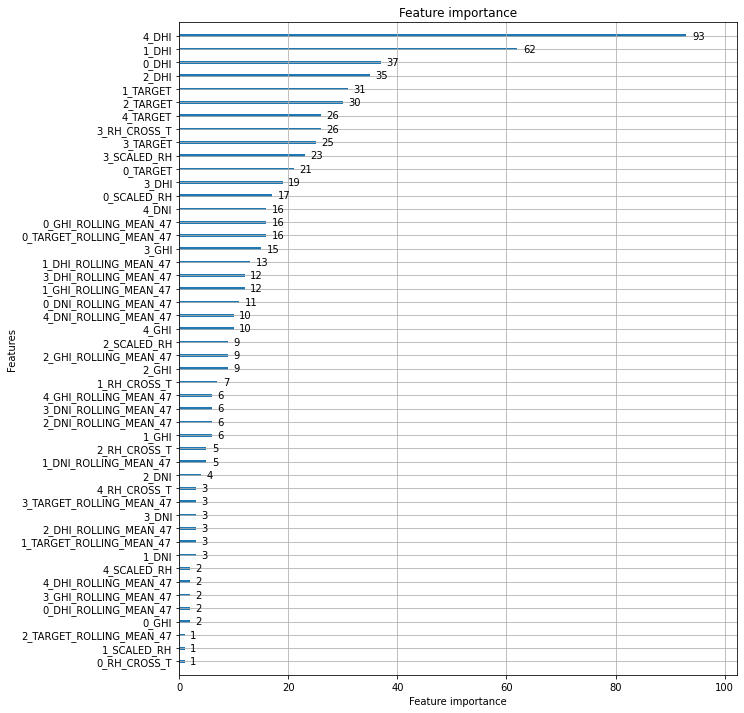

In [22]:
lgb.plot_importance(result_bst_1[0], figsize=(10, 12))

In [9]:
submission_df.to_csv("lightgbm_gbdt_split_dataset_2021_01_13.csv", index=False)